## Analze the data to find any trends

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

In [3]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
import tensorflow_probability as tfp
import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
# from rezaware.modules.etl.loader import sparkRDBM as db
from rezaware.modules.etl.loader import sparkFile as file
# from rezaware.modules.etl.loader import __propAttr__ as attr

''' restart initiate classes '''
if debug:
    import importlib
    # db = importlib.reload(db)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write BigQuery dataset for hypothese testing"

clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    store_mode='local-fs',
    store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)

print("\n%s class initialization and load complete!" % __desc__)

All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
__propAttr__ Class initialization complete
sparkFile Class initialization complete

read and write BigQuery dataset for hypothese testing class initialization and load complete!


## Load Data

In [5]:
options = {
    "inferSchema":True,
    "header":True,
    "delimiter":",",
    "pathGlobFilter":'*.csv',
    "recursiveFileLookup":True,
}

sdf=clsFile.read_files_to_dtype(
    as_type = "SPARK",      # optional - define the data type to return
    folder_path="mining/data/budget/",  # optional - relative path, w.r.t. self.storeRoot
    file_name="complete-60-accounts.csv",  # optional - name of the file to read
    file_type=None,  # optional - read all the files of same type
    **options,
)
print("Loaded %d rows" % sdf.count())

25/02/21 14:08:56 WARN Utils: Your hostname, Waidy-Think-Three resolves to a loopback address: 127.0.1.1; using 192.168.2.82 instead (on interface enp0s25)
25/02/21 14:08:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/02/21 14:08:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
                                                                                

Loaded 61513 rows


## Currency Convert the Spend

In [6]:
### USE python currency-converter librabry with date
sdf = sdf.withColumn(
    "spend_usd",
    F.when(F.col('account_currency').isin('CAD'), F.col('spend') * 0.70)
     .when(F.col('account_currency').isin('EUR'), F.col('spend') * 1.05)
     .when(F.col('account_currency').isin('THB'), F.col('spend') * 0.03)
     .when(F.col('account_currency').isin('INR'), F.col('spend') * 0.012)
     .when(F.col('account_currency').isin('USD'), F.col('spend') * 1.00)
     .otherwise(F.col('spend') * 1.00)
)

# sdf.printSchema()

In [7]:
sdf.groupBy(F.col('goal'), F.col('account_currency')).count()\
    .orderBy(F.col('goal')).show()
# sdf.select('updated_time','spend_usd', 'CPC', 'CPM', 'CTR', 'ROAS', 
#            'account_currency','impressions', 'click', 'reach', 'frequency').where(F.col('goal').isin('REPLIES')).show()

[Stage 14:>                                                         (0 + 1) / 1]

+--------------------+----------------+-----+
|                goal|account_currency|count|
+--------------------+----------------+-----+
|         IMPRESSIONS|             THB|    1|
|         LINK_CLICKS|             USD|   17|
|MESSAGING_PURCHAS...|             THB|  269|
|MESSAGING_PURCHAS...|             USD|    1|
| OFFSITE_CONVERSIONS|             INR|34681|
| OFFSITE_CONVERSIONS|             EUR|  205|
| OFFSITE_CONVERSIONS|             CAD| 5200|
| OFFSITE_CONVERSIONS|             USD|16223|
|     POST_ENGAGEMENT|             THB|    2|
|               REACH|             THB|    1|
|               REACH|             USD|   32|
|             REPLIES|             THB|  417|
|             REPLIES|             CAD| 4040|
|  RETURN_ON_AD_SPEND|             USD|   82|
|  RETURN_ON_AD_SPEND|             INR|  342|
+--------------------+----------------+-----+



## Filtered Dataframe
* goal = OFFSITE_CONVERSIONS
* columns = spend_usd, CPC, CPM, CTR, ROAS,<br><tab><tab>click, impressions, frequency, reach
* column value >= mean + 2 x sigma (95 percentile)
* account_currency = USD (market segment)

In [8]:
_data_sdf= sdf.select('updated_time','spend_usd', 'CPC', 'CPM', 'CTR', 'ROAS',
                      'impressions', 'click', 'reach', 'frequency')\
            .where(F.col('goal').isin('REPLIES')) \
            .dropna().orderBy('updated_time').toPandas()
# _data_sdf= sdf.select('updated_time','spend_usd',
#                      'CPC', 'CPM', 'CTR', 'ROAS', 
#                      'impressions', 'click', 'reach', 'frequency')\
#             .where(F.col('goal').isin('OFFSITE_CONVERSIONS') & \
#                   F.col('account_currency').isin('CAD'))\
#             .dropna().orderBy('updated_time').toPandas()
print(_data_sdf.shape)
''' keep 95 percentile of the data '''
# for _col in _data_df.columns:
#     _data_df = _data_df[_data_df[_col]<=\
#                     _data_df[_col].mean()+2*_data_df[_col].std()]
# _data_df = _data_df.sample(n=1000)

print("data shape:", _data_sdf.shape)
print("some stats:\n", _data_sdf.describe())

(1313, 10)
data shape: (1313, 10)
some stats:
          spend_usd          CPC          CPM          CTR         ROAS  \
count  1313.000000  1313.000000  1313.000000  1313.000000  1313.000000   
mean     13.177998     1.425051    64.003815     4.573616     7.368967   
std      13.987713     1.011975    34.132467     3.066206   100.412233   
min       0.014000     0.000000     5.789474     0.000000     0.005794   
25%       2.891000     0.885111    37.204169     2.507837     0.239250   
50%       7.266000     1.202857    59.333333     4.278075     0.695623   
75%      19.236000     1.745000    85.900000     6.239168     1.633562   
max      80.591000    10.750000   314.000000    25.000000  3324.500000   

       impressions        click        reach    frequency  
count  1313.000000  1313.000000  1313.000000  1313.000000  
mean    345.784463    16.269612   318.175171     1.067327  
std     415.739996    20.158340   374.273921     0.048370  
min       1.000000     0.000000     1.000000  

## Enrich data

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read data from Excel file
df = _data_sdf
df['updated_time']=pd.to_datetime(df['updated_time'])
df['day_of_week']=df['updated_time'].dt.day_name().astype('string')
df['month']=df['updated_time'].dt.month_name().astype('string')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   updated_time  1313 non-null   datetime64[ns]
 1   spend_usd     1313 non-null   float64       
 2   CPC           1313 non-null   float64       
 3   CPM           1313 non-null   float64       
 4   CTR           1313 non-null   float64       
 5   ROAS          1313 non-null   float64       
 6   impressions   1313 non-null   int32         
 7   click         1313 non-null   int32         
 8   reach         1313 non-null   int32         
 9   frequency     1313 non-null   float64       
 10  day_of_week   1313 non-null   string        
 11  month         1313 non-null   string        
dtypes: datetime64[ns](1), float64(6), int32(3), string(2)
memory usage: 107.8 KB


In [11]:
df.corr()

,spend_usd,CPC,CPM,CTR,ROAS,impressions,click,reach,frequency
spend_usd,1.000000,-0.094214,0.078410,0.257901,-0.062700,0.819430,0.933905,0.820355,0.453299
CPC,-0.094214,1.000000,0.216084,-0.197738,-0.081631,-0.144302,-0.221037,-0.144354,-0.064503
CPM,0.078410,0.216084,1.000000,0.463379,-0.050952,-0.233142,-0.032588,-0.241034,0.107562
CTR,0.257901,-0.197738,0.463379,1.000000,-0.036595,0.035702,0.303679,0.031831,0.258411
ROAS,-0.062700,-0.081631,-0.050952,-0.036595,1.000000,-0.054444,-0.053614,-0.055528,-0.083660
impressions,0.819430,-0.144302,-0.233142,0.035702,-0.054444,1.000000,0.864067,0.997963,0.368273
click,0.933905,-0.221037,-0.032588,0.303679,-0.053614,0.864067,1.000000,0.868092,0.415750
reach,0.820355,-0.144354,-0.241034,0.031831,-0.055528,0.997963,0.868092,1.000000,0.342040
frequency,0.453299,-0.064503,0.107562,0.258411,-0.083660,0.368273,0.415750,0.342040,1.000000


In [12]:
from pycaret.regression import *

data = df[['updated_time', 'spend_usd', 'impressions', 'click', 'reach', 'frequency']]
s = setup(data, target='spend_usd', session_id = 123)
best = compare_models()
evaluate_model(best)
pre_holdout = predict_model(best)

new_df = data.copy().drop(['spend_usd'], axis=1)
predictions = predict_model(best, data=new_df)
save_model(best, 'best_pipeline')

,Description,Value
0,Session id,123
1,Target,spend_usd
2,Target type,Regression
3,Original data shape,"(1313, 6)"
4,Transformed data shape,"(1313, 8)"
5,Transformed train set shape,"(919, 8)"
6,Transformed test set shape,"(394, 8)"
7,Numeric features,4
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.2134,11.9721,3.4130,0.9373,0.2589,0.3205,0.1770
gbr,Gradient Boosting Regressor,2.2261,12.0139,3.4230,0.9371,0.2683,0.4278,0.1100
rf,Random Forest Regressor,2.2428,12.0391,3.4192,0.9367,0.2654,0.3286,0.2680
lightgbm,Light Gradient Boosting Machine,2.2858,13.4050,3.5998,0.9299,0.2662,0.3930,28.1510
ada,AdaBoost Regressor,3.5430,19.9157,4.4366,0.8938,0.5453,2.3203,0.0910
dt,Decision Tree Regressor,2.8781,20.3419,4.4154,0.8937,0.3478,0.4094,0.0360
lr,Linear Regression,3.0861,21.8412,4.5268,0.8863,0.4332,1.0848,3.4360
ridge,Ridge Regression,3.0906,22.0042,4.5306,0.8852,0.4330,1.1640,0.0700
br,Bayesian Ridge,3.0933,22.0467,4.5397,0.8852,0.4335,1.1417,0.0450
en,Elastic Net,3.3101,25.6570,4.9150,0.8651,0.4103,1.2040,0.0320


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.5412,15.7564,3.9694,0.9234,0.2643,0.3170


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['updated_time'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['impressions', 'click', 'reach',
                                              'frequency'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  ExtraTreesRegressor(n_jobs=-1, random_state=123))]),
 'best_pipeline.pkl')

<Axes: xlabel='dates'>

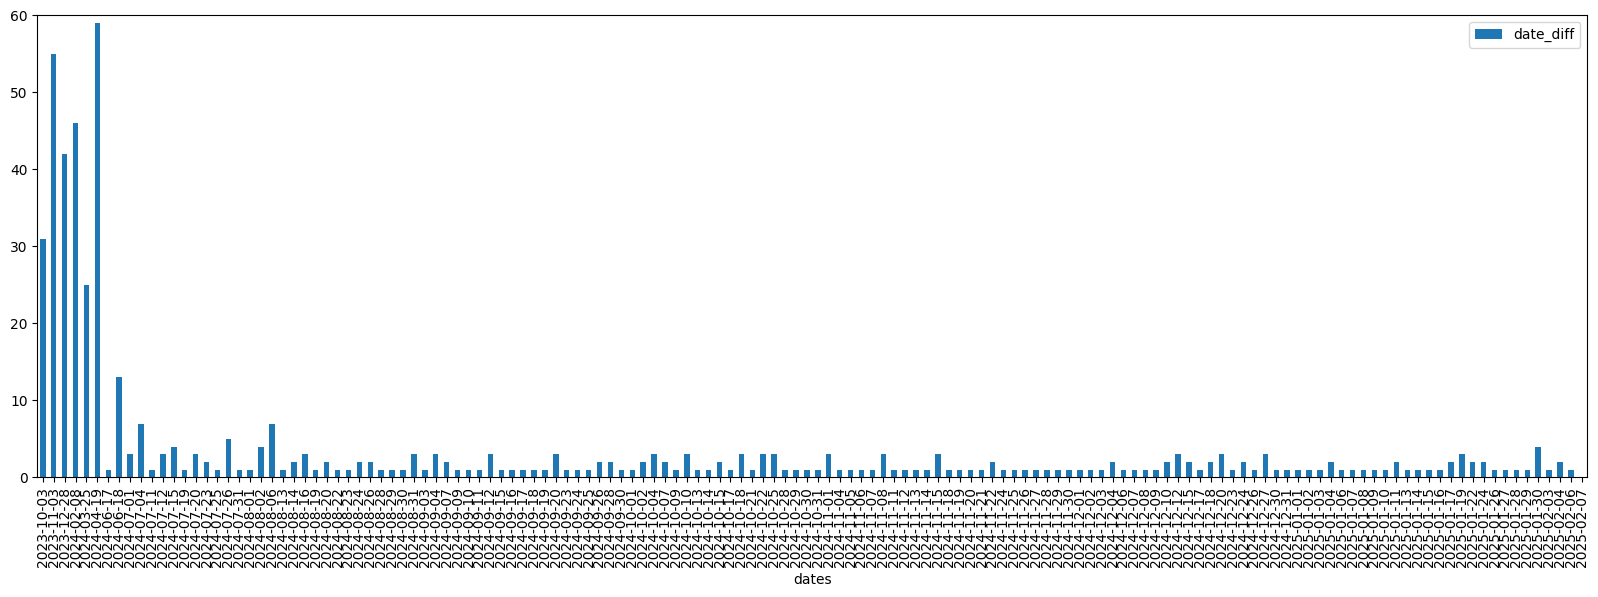

In [88]:
d_df.plot(x='dates',y='date_diff', kind='bar', figsize=(20,6), ylim=(0, 60))
# d_df.info()

In [76]:
dates_arr = _data_df.sort_values(by='updated_time', ascending=True)['updated_time'].unique()
d_df = pd.DataFrame(dates_arr, columns=['dates'])
d_df['dates_shift'] = d_df['dates'].shift(-1)
d_df['date_diff'] = (d_df['dates_shift'] - d_df['dates']) / pd.Timedelta(days=1)
d_df['date_diff'].describe()

count    141.000000
mean       3.496454
std        8.841965
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       59.000000
Name: date_diff, dtype: float64

<Axes: xlabel='updated_time'>

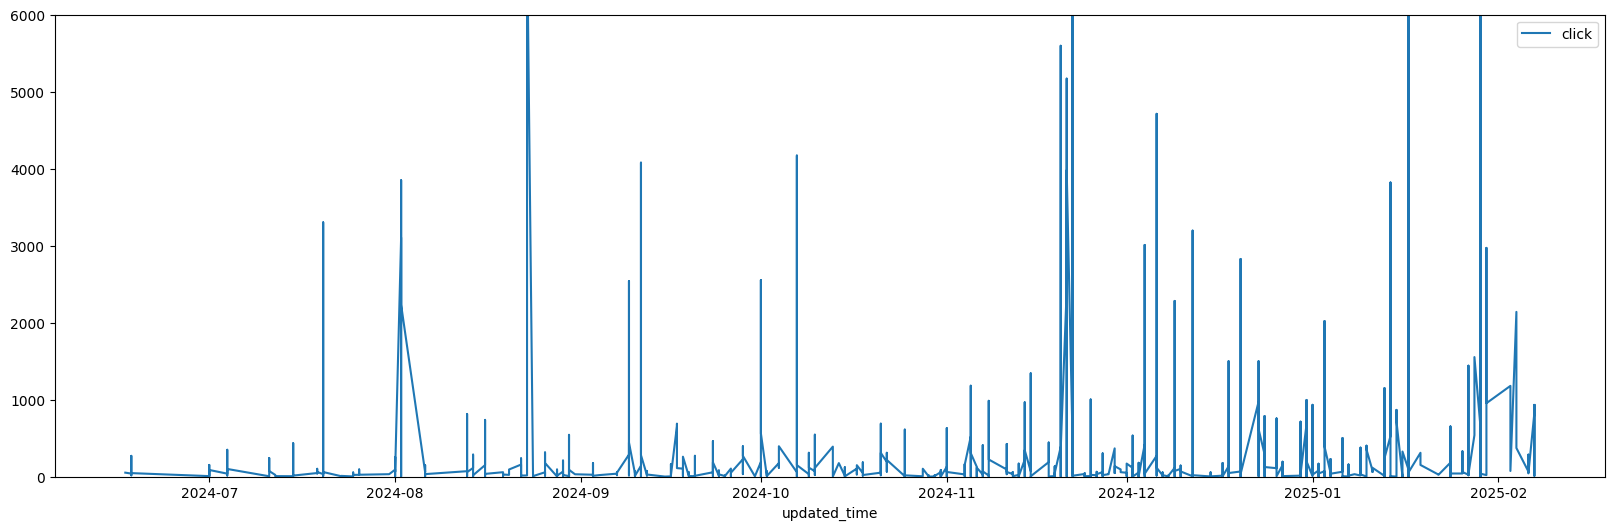

In [90]:
from datetime import date

df=_data_df[_data_df['updated_time']>=date(2024,6,1)]
df.plot(x='updated_time', y='click', figsize=(20,6), ylim=(0, 6000))

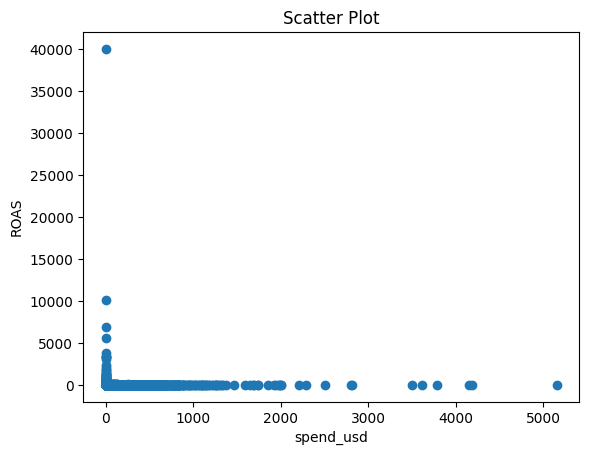

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

_data_df = sdf.toPandas()
_x_col, _y_col = 'spend_usd', 'ROAS' #, 'reach'
plt.scatter(_data_df[_x_col],_data_df[_y_col])
plt.title("Scatter Plot")
plt.xlabel(_x_col)
plt.ylabel(_y_col)
plt.show()

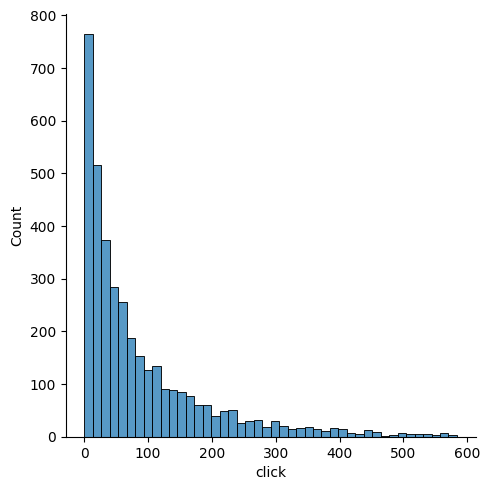

In [10]:
import seaborn as sns 

# sns.displot(_data_df, x=_x_col)
sns.displot(_data_df, x=_y_col)

<Axes: xlabel='updated_time'>

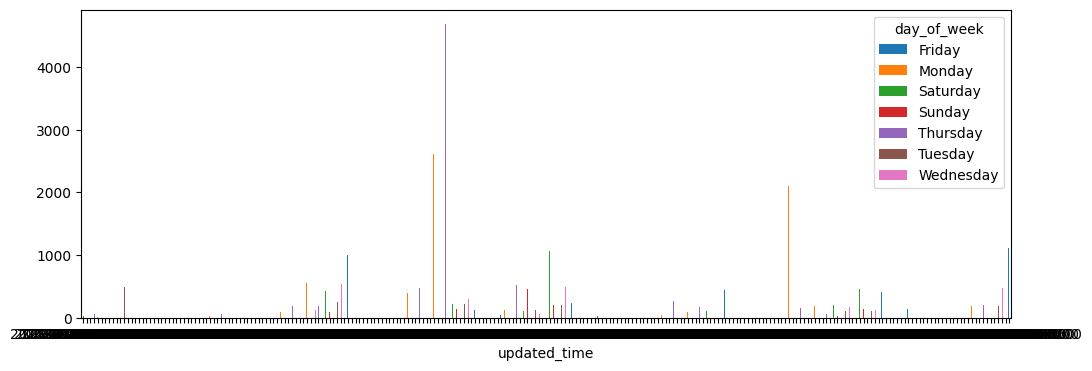

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_df = dow_df.pivot(index="updated_time", 
                       columns="day_of_week", values="click_sum")

fig, axs = plt.subplots(figsize=(12, 4))

plot_df.plot(kind='bar', rot=0, ax=axs)